In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import 

## Data mining and cleaning

In [58]:
toyota_data = pd.read_csv("cars_toyota.csv")
kia_data = pd.read_csv("cars_kia.csv")
mazda_data = pd.read_csv("cars_mazda.csv")
hyundai_data = pd.read_csv("cars_hyundai.csv")

According to the table above, there is the column that must be deleted
Also, `car_price` and `car_description` contain unstructured data. For example, the car's year can be a separate column as well the engine characteristics, mileage etc. 

In [59]:
toyota_data = toyota_data.drop("Unnamed: 0" ,axis=1)
kia_data = kia_data.drop("Unnamed: 0" ,axis=1)
mazda_data = mazda_data.drop("Unnamed: 0" ,axis=1)
hyundai_data = hyundai_data.drop("Unnamed: 0" ,axis=1)

In [60]:
toyota_data.rename(columns={"car_titlem": "car_title"}, inplace=True)
kia_data.rename(columns={"car_titlem": "car_title"}, inplace=True)
hyundai_data.rename(columns={"car_titlem": "car_title"}, inplace=True)

Remove `car_price`'s chars

In [61]:
frames = [toyota_data, kia_data, mazda_data, hyundai_data]
data = pd.concat(frames)

In [62]:
data["car_price"] = data["car_price"].str.replace(" ", "")
data["car_price"] = data["car_price"].str.replace("₸", "")
# Later I may need to transform `car_price` into float

Split `car_description` to get additional information on car selling details

In [63]:
# regex patterns to extract information into seperate columns and then remove it from the previous one
order_pat = r'новая[,\/]?|на заказ[,\/]?'
asap_pat = r'срочно[,\/]?|[торг]{4}?[,\/]?'
broken_pat = r'не на ходу[,\/]?|аварийная[,\/]?'

In [64]:
data["car_description"] = data["car_description"].str.replace("торг[,\/]?", "")
data["car_description"] = data["car_description"].str.replace(" ", "")

In [65]:
data["pre_order"] = data["car_description"].str.contains(pat=order_pat)
data["car_description"] = data["car_description"].str.replace(order_pat, "")

In [66]:
data["asap_negotiable"] = data["car_description"].str.contains(pat=asap_pat)
data["car_description"] = data["car_description"].str.replace(asap_pat, "")

In [67]:
data["broken"] = data["car_description"].str.contains(pat=broken_pat)
data["car_description"] = data["car_description"].str.replace(broken_pat, "")

All the details related to selling are extracted and prepared. Now I will get details about the cars

In [68]:
# regex patterns to extract data into seperate columns from the description
year_pat = r'(\d{4})'
odometer_pat = r'(\d+?\.*\d*(?=км))'
engine_pat = r'(\d+?\.*\d*(?=л))'

In [69]:
#extract information into separate columns from the description
data["car_year"] = data["car_description"].str.extract(pat=year_pat)
data["odometer"] = data["car_description"].str.extract(pat=odometer_pat)
data["engine"] = data["car_description"].str.extract(pat=engine_pat)

In [70]:
#remove the 'description' column
data.drop("car_description", axis=1, inplace=True)

In [71]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48665 entries, 0 to 3343
Data columns (total 9 columns):
car_title          48665 non-null object
car_price          48665 non-null object
car_location       48665 non-null object
pre_order          48665 non-null bool
asap_negotiable    48665 non-null bool
broken             48665 non-null bool
car_year           48665 non-null object
odometer           39550 non-null object
engine             48665 non-null object
dtypes: bool(3), object(6)
memory usage: 2.7+ MB


In [72]:
#before I change data types of values I would like to remove broken cars from the dataframe
data.drop(data[data["broken"]==True].index, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48445 entries, 0 to 3343
Data columns (total 9 columns):
car_title          48445 non-null object
car_price          48445 non-null object
car_location       48445 non-null object
pre_order          48445 non-null bool
asap_negotiable    48445 non-null bool
broken             48445 non-null bool
car_year           48445 non-null object
odometer           39410 non-null object
engine             48445 non-null object
dtypes: bool(3), object(6)
memory usage: 2.7+ MB


In [73]:
data.drop("broken", axis=1, inplace=True)

In [74]:
data[["car_price", "car_year", "odometer", "engine"]] = data[["car_price", "car_year", "odometer", "engine"]].astype(float)

In [75]:
#Now I need to identify what to do with the missing odometer values
data["odometer"].value_counts(dropna=False)

NaN         9035
120000.0     680
140000.0     640
80000.0      640
90000.0      552
            ... 
86373.0       20
50743.0       12
43500.0       11
114465.0      11
77200.0       11
Name: odometer, Length: 585, dtype: int64

**According to common sense if cars are manufactured in 2019 (or 2018 in rare cases) they are new and thus odometer is 0. Let's check how many values will be left after applying it.**

In [76]:
def assign_odometer(x):
    if (x["car_year"] == 2019.0 or x["car_year"] == 2018.0) and np.isnan(x["odometer"]):
        return 0.0
    else: 
        return x["odometer"]

In [77]:
data["odometer"] = data.apply(assign_odometer, axis=1)

In [78]:
data["odometer"].value_counts(dropna=False)

NaN         5435
0.0         3600
120000.0     680
140000.0     640
80000.0      640
            ... 
31703.0       20
50743.0       12
43500.0       11
114465.0      11
77200.0       11
Name: odometer, Length: 586, dtype: int64

In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48445 entries, 0 to 3343
Data columns (total 8 columns):
car_title          48445 non-null object
car_price          48445 non-null float64
car_location       48445 non-null object
pre_order          48445 non-null bool
asap_negotiable    48445 non-null bool
car_year           48445 non-null float64
odometer           43010 non-null float64
engine             48445 non-null float64
dtypes: bool(2), float64(4), object(2)
memory usage: 2.7+ MB


In [80]:
no_odometer = data.loc[np.isnan(data["odometer"])]
no_odometer.head()

,car_title,car_price,car_location,pre_order,asap_negotiable,car_year,odometer,engine
806,Toyota Camry,5800000.0,Актобе,False,False,2012.0,NaN,3.5
826,Toyota Camry,5800000.0,Актобе,False,False,2012.0,NaN,3.5
846,Toyota Camry,5800000.0,Актобе,False,False,2012.0,NaN,3.5
866,Toyota Camry,5800000.0,Актобе,False,False,2012.0,NaN,3.5
886,Toyota Camry,5800000.0,Актобе,False,False,2012.0,NaN,3.5


By checking rows with NaN odometer I found out that these are duplicate values (most of it) and must be dropped from the dataframe

In [81]:
data = data.loc[data["odometer"].notna()]

In [82]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43010 entries, 0 to 3343
Data columns (total 8 columns):
car_title          43010 non-null object
car_price          43010 non-null float64
car_location       43010 non-null object
pre_order          43010 non-null bool
asap_negotiable    43010 non-null bool
car_year           43010 non-null float64
odometer           43010 non-null float64
engine             43010 non-null float64
dtypes: bool(2), float64(4), object(2)
memory usage: 2.4+ MB


## Now I will visualize my data to understand better what am I working with

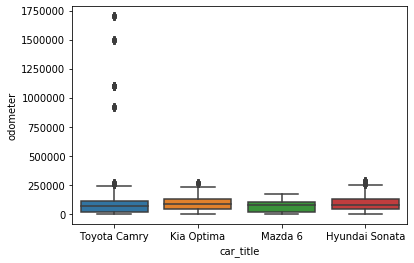

In [83]:
ax = sns.boxplot(x="car_title", y="odometer", data=data)

According to the graph above, there are several outliers which should be removed as it's number is very low.

In [84]:
data = data.loc[data["odometer"]<250000]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42770 entries, 0 to 3343
Data columns (total 8 columns):
car_title          42770 non-null object
car_price          42770 non-null float64
car_location       42770 non-null object
pre_order          42770 non-null bool
asap_negotiable    42770 non-null bool
car_year           42770 non-null float64
odometer           42770 non-null float64
engine             42770 non-null float64
dtypes: bool(2), float64(4), object(2)
memory usage: 2.4+ MB


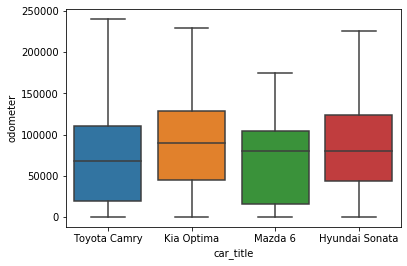

In [85]:
ax = sns.boxplot(x="car_title", y="odometer", data=data)

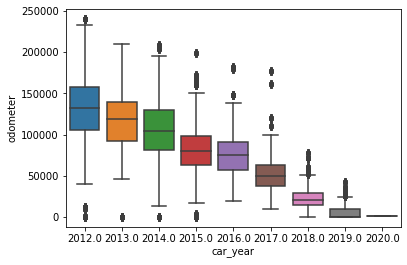

In [86]:
ax = sns.boxplot(x="car_year", y="odometer", data=data)

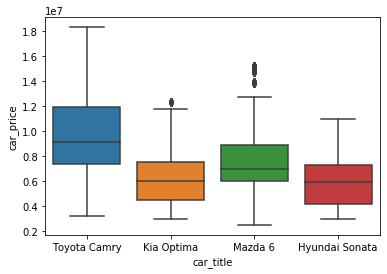

In [87]:
ax = sns.boxplot(x="car_title", y="car_price", data=data)

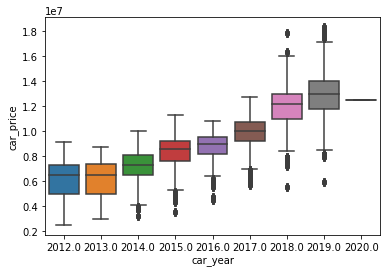

In [88]:
ax = sns.boxplot(x="car_year", y="car_price", data=data)

In [93]:
car_title_dict = {"Toyota Camry": 1, "Kia Optima": 2, "Hyundai Sonata": 3, "Mazda 6": 4}
data["car_title"] = data["car_title"].map(car_title_dict)

In [97]:
data_corr = data.corr()

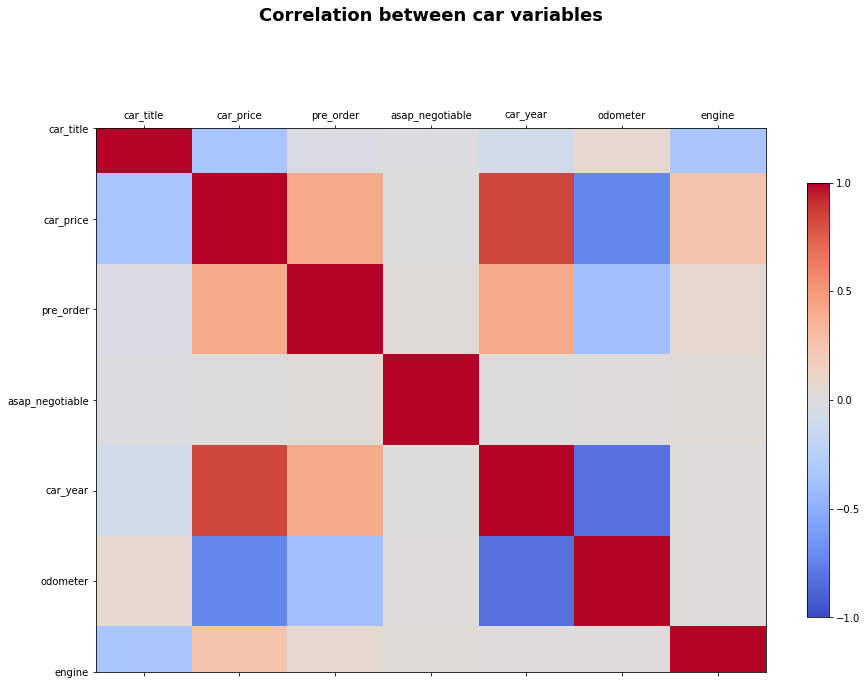

In [98]:
fig, ax = plt.subplots(figsize=(15,10))
cax = ax.matshow(data_corr, cmap="coolwarm", vmin=-1, vmax=1, aspect="auto")
x = np.arange(len(data_corr.columns))

ax.set_title("Correlation between car variables", {"fontsize": 18, "fontweight": "bold"}, pad=80)
fig.colorbar(cax, ticks=[-1,-0.5,0,0.5,1], shrink=0.8)
ax.set_xticks(x)
ax.set_yticks(x)
ax.set_xticklabels(data_corr.columns)
ax.set_yticklabels(data_corr.columns)
plt.show()

As negotiability does not have significant relationship with other variables, it can be removed from the dataset. Intuitionally, older cars are cheaper as well as the cars with bigger traveled distance. Cars that require pre-order may cost higher as well as the powerful cars.

### Creating train and test sets

In [99]:
data.head()

,car_title,car_price,car_location,pre_order,asap_negotiable,car_year,odometer,engine
0,1,10700000.0,Костанай,False,False,2019.0,12000.0,2.0
1,1,11900000.0,Костанай,False,False,2018.0,40000.0,2.5
2,1,10600000.0,Шымкент,False,False,2017.0,32686.0,2.5
3,1,13300000.0,Нур-Султан (Астана),False,False,2018.0,18100.0,2.5
5,1,10200000.0,Атырау,False,False,2016.0,59000.0,2.5


In [100]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris